# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [113]:
import torch
import hydra
import copy
import numpy as np
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=modern'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [49]:
with open_dict(cfg):
    cfg.case.data.partition = "balanced"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 1
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

    cfg.attack.regularization.total_variation.scale = 0.2
    cfg.attack.regularization.total_variation.inner_exp = 2
    cfg.attack.regularization.total_variation.outer_exp = 0.5
    # cfg.attack.optim.signed = 'hard'
    cfg.attack.optim.step_size_decay = 'cosine-decay'
    cfg.attack.optim.warmup = 50
    # cfg.attack.optim.step_size = 1e-2
    cfg.attack.init = 'patterned-4'  # 'patterned-4'
    cfg.attack.objective.task_regularization = .0
    cfg.attack.regularization.features = .0

    cfg.attack.regularization.total_variation.double_opponents = True
    cfg.attack.regularization.deep_inversion = dict(scale=.0)

    cfg.attack.optim.max_iterations = 0

### Instantiate all parties

In [39]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      19:1 for target shape [4, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents (

In [40]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents (double opp.)
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: soft
        step_size: 0.1
        boxed: True
        max_iterations: 0
        ste

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [41]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [158]:
cfg.case.user.num_data_points = 2

In [159]:
# reconstruct features from users
all_features = []
for i in tqdm(range(50 // cfg.case.user.num_data_points)):
    with open_dict(cfg):
        cfg.case.user.user_idx = i
    user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
    attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)  
    all_features.append(torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain)).cpu().detach().numpy())

all_features = np.array(all_features)

100%|█████████████████████████████████████| 25/25 [00:50<00:00,  2.01s/it]


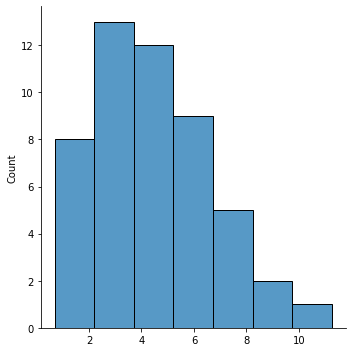

In [111]:
sns.displot(all_features[:, 141])

In [42]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

### Reconstruct user data:

In [9]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.0180 |  Task loss: 942.4099 | T: 0.62s
| It: 1001 | Rec. loss: 0.2386 |  Task loss: 671.3671 | T: 71.51s
| It: 2001 | Rec. loss: 0.2246 |  Task loss: 678.9722 | T: 64.92s
| It: 3001 | Rec. loss: 0.2093 |  Task loss: 682.2296 | T: 64.79s
| It: 4001 | Rec. loss: 0.2182 |  Task loss: 687.2621 | T: 64.76s
| It: 5001 | Rec. loss: 0.2457 |  Task loss: 670.8041 | T: 65.05s
| It: 6001 | Rec. loss: 0.2043 |  Task loss: 680.3107 | T: 65.09s
| It: 7001 | Rec. loss: 0.2016 |  Task loss: 677.1419 | T: 64.89s
| It: 8001 | Rec. loss: 0.1824 |  Task loss: 684.6504 | T: 65.20s
| It: 9001 | Rec. loss: 0.1852 |  Task loss: 670.1359 | T: 65.08s
| It: 10001 | Rec. loss: 0.1643 |  Task loss: 685.2788 | T: 65.63s
| It: 11001 | Rec. loss: 0.1925 |  Task loss: 680.1074 | T: 64.42s
| It: 12001 | Rec. loss: 0.1852 |  Task loss: 674.1434 | T: 65.01s
| It: 13001 | Rec. loss: 0.1718 |  Task loss: 685.6941 | T: 64.90s
| It: 14001 | Rec. loss: 0.1299 |  Task loss: 696.0327 | T: 64.77s
| It: 150

In [11]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

D:\anaconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0092 | PSNR: 20.38 | FMSE: 1.7127e+03 | LPIPS: 0.34|
 R-PSNR: 20.51 | IIP-pixel: 100.00% | SSIM: 0.4455 | Label Acc: 100.00%


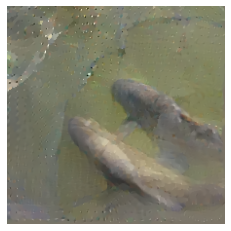

In [12]:
user.plot(reconstructed_user_data)

In [114]:
*_, l_w, l_b = server.model.parameters()

In [135]:
mean_feature = np.mean(all_features, axis=0)

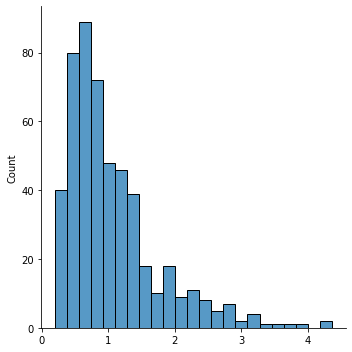

In [138]:
sns.displot(mean_feature)

In [ ]:
server.model.model.fc(torch.tensor(all_features[0, :]))

1.5085094 0.999905


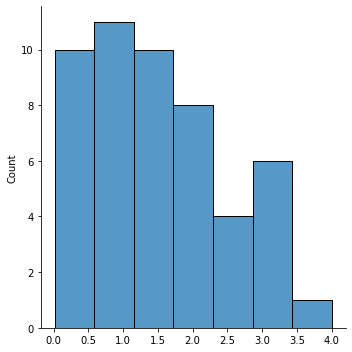

In [163]:
f_ind = 100
tmp_series = gt_features[:, f_ind]
sns.displot(tmp_series)
print(np.mean(tmp_series), np.std(tmp_series))

1.4306531 0.9424484


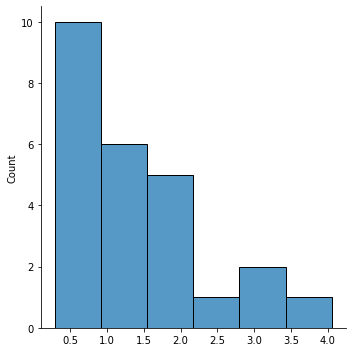

In [164]:
tmp_series = all_features[:, f_ind]
sns.displot(tmp_series)
print(np.mean(tmp_series), np.std(tmp_series))